In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader

from skpm import event_logs

from ppm.datasets import ContinuousTraces
from ppm.datasets.event_logs import EventFeatures, EventLog, EventTargets
from ppm.datasets.utils import continuous
from ppm.models import NextEventPredictor
from ppm.engine.utils import load_checkpoint
from ppm.utils import parse_args, get_model_config, prepare_data, calculate_accuracy

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1


# Prepare data & model

In [2]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

NUMERICAL_FEATURES = [
    "accumulated_time",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "hour_of_day",
    "min_of_hour",
    "month_of_year",
    "sec_of_min",
    "secs_within_day",
    "week_of_year",
]

In [3]:
config_path = r'D:\PycharmProjects\xAI-PPM\configs\explain_lstm_args.txt'
checkpoints_path = r'D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_lstm_single_task_na_no_posenc.pth'

args = parse_args(config_path=config_path)
args.dataset = 'BPI17'

config = {
    # args to pop before logging
    "project_name": args.project_name,
    "checkpoint_path": checkpoints_path,
    # args to log
    "log": args.dataset,
    "device": args.device,
    # architecture
    "backbone": args.backbone,
    "rnn_type": args.rnn_type,
    "embedding_size": args.embedding_size,
    "hidden_size": args.hidden_size,
    "n_layers": args.n_layers,
    # hyperparameters
    "batch_size": 1,       
    # features and tasks
    "categorical_features": args.categorical_features,
    "continuous_features": (
        NUMERICAL_FEATURES
        if (
            args.continuous_features is not None
            and "all" in args.continuous_features
        )
        else args.continuous_features
    ),
    "categorical_targets": args.categorical_targets,
    "continuous_targets": args.continuous_targets,
    "strategy": args.strategy,
    # "pos_encoding_form": None,
    # "pos_encoding_strategy": "sum"
}

In [4]:
log = getattr(event_logs, config["log"])()
result = prepare_data(
    log.dataframe, log.unbiased_split_params, NUMERICAL_FEATURES, return_timestamps=True
)

# prepare_data may return either (train, test) or (train, test, train_timestamps, test_timestamps)
if isinstance(result, tuple) and len(result) == 4:
    train, test, _, test_timestamps = result
elif isinstance(result, tuple) and len(result) == 2:
    train, test = result
else:
    raise ValueError("Unexpected return value from prepare_data()")

event_features = EventFeatures(
    categorical=config["categorical_features"],
    numerical=config["continuous_features"],
)
event_targets = EventTargets(
    categorical=config["categorical_targets"],
    numerical=config["continuous_targets"],
)

train_log = EventLog(
    dataframe=train,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=True,
    name=config["log"],
)

test_log = EventLog(
    dataframe=test,
    case_id="case_id",
    features=event_features,
    targets=event_targets,
    train_split=False,
    name=config["log"],
    vocabs=train_log.get_vocabs(),
)

dataset_device = (
    config["device"]
    if config["backbone"]
    not in ["gpt2", "llama32-1b", "llama2-7b", "qwen25-05b"]
    else "cpu"
)

train_dataset = ContinuousTraces(
    log=train_log,
    refresh_cache=True,
    device=dataset_device,
)
test_dataset = ContinuousTraces(
    log=test_log,
    refresh_cache=True,
    device=dataset_device,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    collate_fn=continuous,
)

In [5]:
# Loading a pre-trained model
model_config = get_model_config(test_log, config)

model = NextEventPredictor(**model_config).to(device=config["device"])
ckpt = load_checkpoint(config["checkpoint_path"], map_location=config["device"])
if isinstance(ckpt, dict) and 'net' in ckpt.keys():
    ckpt = ckpt['net']
model.load_state_dict(ckpt)

 [*] Loading checkpoint from D:\PycharmProjects\xAI-PPM\persisted_models\suffix\BPI17_lstm_single_task_na_no_posenc.pth succeed!


<All keys matched successfully>

In [6]:
calculate_accuracy(model, test_loader, device='cpu')

Accuracy of the model: 86.435%


# Extract cases for generating explanations

In [7]:
# a) Extracting sequences that predicted to have "O_Accepted" as the next activity of the given trace

o_cancelled_token = 14
o_cancelled_ids = []
o_cancelled_cases = []


for ind, batch in enumerate(test_loader):
    x_cat, x_num, _, _ = batch # type: ignore
    x_cat, x_num = x_cat[:, :-1, :], x_num[:, :-1, :]
    x_cat, x_num = (x_cat.to(dataset_device), x_num.to(dataset_device))

    attention_mask = (x_cat[..., 0] != 0).long()
    out, _ = model(x_cat=x_cat, x_num=x_num, attention_mask=attention_mask)
    pred_last_event = torch.argmax(out['next_activity'][:, -1, :]).cpu().item()

    if pred_last_event == o_cancelled_token:
        o_cancelled_ids.append(ind)     
        case_to_explain = np.concatenate([x_cat.numpy(), x_num.numpy()], axis=-1)
        o_cancelled_cases.append(case_to_explain)  

print(f'The following {len(o_cancelled_cases)} cases that derived "O_Cancelled" prediction for the next activity will be explained')


The following 228 cases that derived "O_Cancelled" prediction for the next activity will be explained


In [8]:
o_created_ind = 15
one_offer_ids = []
multiple_offers = []

# Extracting cases ids from the o_cancelled_cases list with only one offer event in the trace
for i, case in enumerate(o_cancelled_cases): 
    offered_times = np.where(case[0, :, 0] == o_created_ind)[0].size 
    if offered_times == 1:
        one_offer_ids.append(i)
    else:
        multiple_offers.append(offered_times)

In [9]:
mo_statistics = {}


for item in multiple_offers:
    if item in mo_statistics.keys():
        mo_statistics[item] += 1
    else:
        mo_statistics[item] = 1
mo_statistics_perc = {k: np.round((v/len(multiple_offers))*100, 2) for k, v in mo_statistics.items()}
mo_statistics_perc, mo_statistics

({2: 71.68, 3: 19.08, 5: 2.31, 7: 0.58, 4: 5.2, 9: 0.58, 6: 0.58},
 {2: 124, 3: 33, 5: 4, 7: 1, 4: 9, 9: 1, 6: 1})

In [10]:
oc_trace_id = one_offer_ids[0]
trace_id_testlog = o_cancelled_ids[oc_trace_id]
print('Id of the case to be explaianed:', trace_id_testlog)
case_to_segment = o_cancelled_cases[oc_trace_id]
print('Case length:', case_to_segment.shape[1])

Id of the case to be explaianed: 295
Case length: 64


In [11]:
explicand_ids = test_dataset.traces[o_cancelled_ids[oc_trace_id]].tolist()
explicand_timestamps = test_timestamps.iloc[explicand_ids]

### Analyze features of the trace 

In [12]:
print("Control-flow of the trace with the index ")
print(("-".join([str(int(i)) for i in case_to_segment[:, :, 0][0]])))  
print("Trace length: ", case_to_segment.shape[1])

Control-flow of the trace with the index 
7-11-25-25-25-25-25-24-24-6-24-24-24-24-24-24-24-24-24-3-15-16-19-24-22-22-5-22-22-22-22-22-22-22-22-22-22-27-27-12-18-27-27-27-27-23-23-9-23-23-23-23-23-23-23-23-23-23-23-23-23-23-4-14
Trace length:  64


Text(0.5, 0, 'Events')

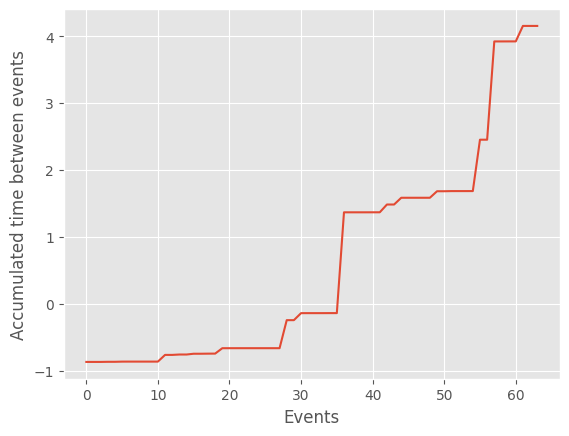

In [13]:
plt.style.use('ggplot')
plt.plot(case_to_segment[:, :, 1][0])
plt.ylabel('Accumulated time between events')
plt.xlabel('Events')

# Trace Segmentation

### Distribution-based Segmentation

In [14]:
import torch
import numpy as np
import seaborn as sns
import colorcet as cc
from itertools import chain

from typing import List
from functools import partial
from local_xai.trace_segmentation.utils import visualize_trace_vertical, plot_segmented_deltas

from local_xai.trace_segmentation.distribution_based import distribution_based_segmentation, initial_trace_segmentation, calculate_mmd_distance, extract_subsequences

In [15]:
def generate_embeddings(model, input: np.ndarray, categorical_indices: List[int]) -> torch.Tensor:
    """
    Generate embeddings for the input sequence using the provided model."""

    device = next(model.parameters()).device
    # separate categorical and numerical features
    if len(input.shape) == 2:
        input = np.expand_dims(input, axis=0)
    total_features_num = input.shape[-1]
    numerical_indices = np.setdiff1d(
        np.arange(total_features_num), categorical_indices
    )
    categorical_features = input[:, :, categorical_indices]
    numerical_features = input[:, :, numerical_indices]

    x_cat, x_num = (
        torch.Tensor(categorical_features).long().to(device),
        torch.Tensor(numerical_features).to(device),
    )

    with torch.no_grad():
        embeddings = model.in_layer(x_cat, x_num)
        embeddings = model.backbone(embeddings)[0]
        embeddings = embeddings.cpu().detach().numpy().squeeze(0)

    return embeddings

In [16]:
intial_seg_ids = initial_trace_segmentation(explicand_timestamps[:-1],  min_window_size=3, max_window_size=5)
print(intial_seg_ids)
print("Number of initial segments:", len(intial_seg_ids))
K = int(min(max(10, len(intial_seg_ids)/2), 30))
print('Number of segments K to be found in the distribution-based segmentation:', K) 

The time window threshold for the initial segmentation is set to: 40735.25156
[{0, 1, 2, 3}, {4, 5, 6}, {8, 9, 7}, {10, 11, 12}, {13, 14, 15}, {16, 17, 18}, {19, 20, 21}, {24, 22, 23}, {25, 26, 27}, {28, 29, 30}, {32, 33, 31}, {34, 35, 36}, {37, 38, 39}, {40, 41, 42}, {43, 44, 45}, {48, 46, 47}, {49, 50, 51}, {52, 53, 54}, {56, 57, 55}, {58, 59, 60}, {61, 62, 63}]
Number of initial segments: 21
Number of segments K to be found in the distribution-based segmentation: 10


In [17]:
embedding_generator = partial(generate_embeddings, model, categorical_indices=[0])
seg_ids = distribution_based_segmentation(
    trace=case_to_segment.squeeze(0),  S_init=intial_seg_ids, K=K, m=5, 
    D=calculate_mmd_distance, embedding_generator=embedding_generator)
seg_ids = [sorted(list(set().union(*seg))) for seg in seg_ids]
seg_ids

[[0, 1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42],
 [43, 44, 45, 46, 47, 48, 49, 50, 51],
 [52, 53, 54],
 [55, 56, 57],
 [58, 59, 60, 61, 62, 63]]

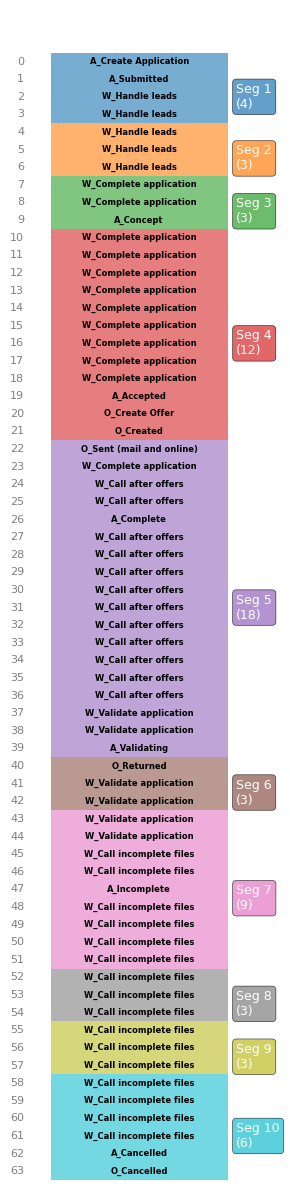

In [18]:
seg_ids_boundaries = {}
palette = sns.color_palette(cc.glasbey_category10, n_colors=len(seg_ids))

for c, seg in enumerate(seg_ids):
    seg_ids_boundaries[(seg[0], seg[-1])] = palette[c]

visualize_trace_vertical(trace=case_to_segment.squeeze(0), activity_token_index=0, figsize=(3, 12),
                         seg_boundaries_colors=seg_ids_boundaries, activity_lookup=test_log.itos['activity'])

### Adjacency-based segmentation

In [19]:
from local_xai.trace_segmentation.transition_based import segment_by_threshold

C:\Users\sahat\AppData\Local\Temp\ipykernel_7644\4243791003.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)


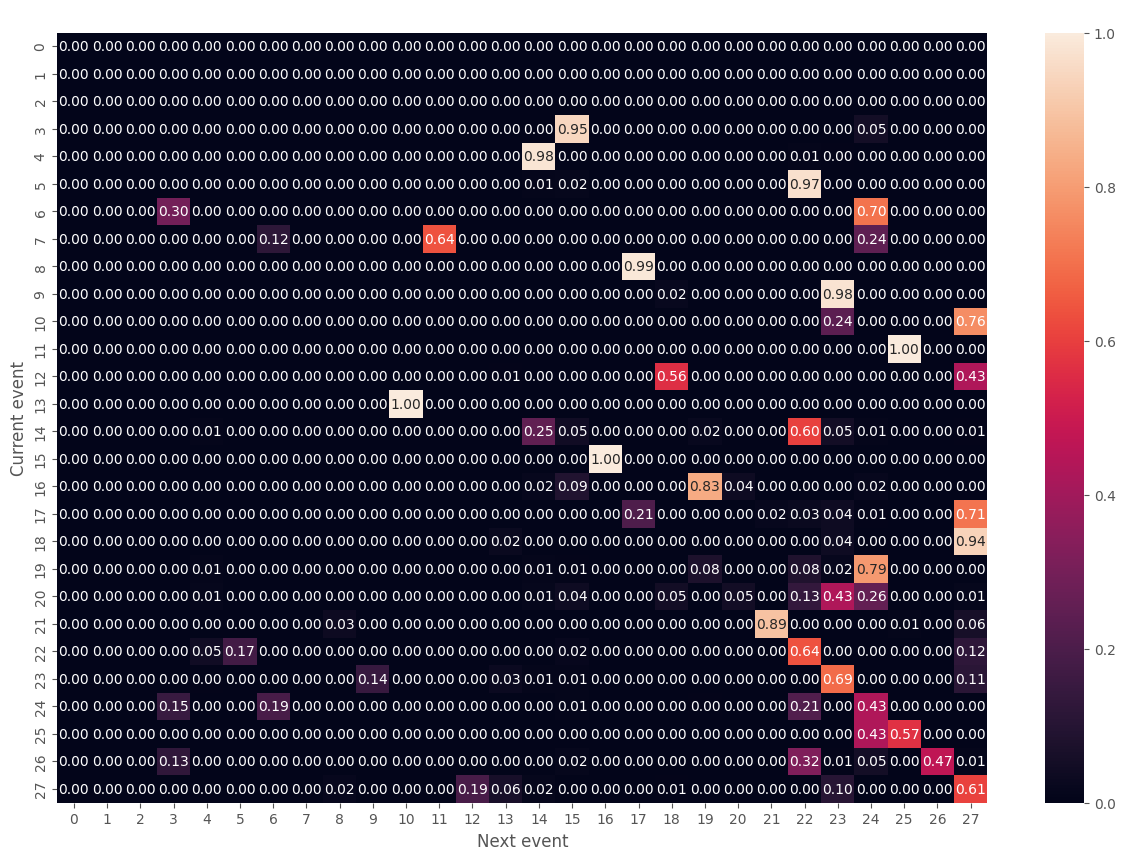

In [20]:
special_tokens = [0, 1, 2]
n_rows = len(special_tokens) + train_log.dataframe['activity'].nunique()
n_cols = len(special_tokens) + train_log.dataframe['activity'].nunique()
adjacency = np.zeros((n_rows, n_cols), dtype=int)

for case_id, group in train_log.dataframe.groupby('case_id'):
    activities = group['activity'].values    
    for i in range(len(activities) - 1):
        adjacency[activities[i], activities[i + 1]] += 1

normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)
normalized_adjacency = np.nan_to_num(normalized_adjacency).astype(np.float64)


plt.figure(figsize=(15, 10))
ax = sns.heatmap(normalized_adjacency, annot=True, fmt=".2f", )
ax.set_title('Normalized Adjacency Matrix (Event Log)')
ax.set_xlabel('Next event')
ax.set_ylabel('Current event')
plt.show()

In [33]:
np.linalg.eig(normalized_adjacency).eigenvalues.reshape(-1, 1)

array([[ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.36722482+0.53248645j],
       [ 0.36722482-0.53248645j],
       [ 1.        +0.j        ],
       [ 0.91613464+0.j        ],
       [ 0.89250536+0.j        ],
       [ 0.84078775+0.j        ],
       [ 0.77624854+0.j        ],
       [-0.37421125+0.3486708j ],
       [-0.37421125-0.3486708j ],
       [-0.14110774+0.37804792j],
       [-0.14110774-0.37804792j],
       [ 0.56928748+0.j        ],
       [ 0.46895448+0.j        ],
       [-0.36012493+0.j        ],
       [ 0.18970915+0.00639638j],
       [ 0.18970915-0.00639638j],
       [-0.00919754+0.12112632j],
       [-0.00919754-0.12112632j],
       [-0.15485888+0.j        ],
       [-0.09235435+0.03505013j],
       [-0.09235435-0.03505013j],
       [ 0.05044273+0.j        ],
       [ 0.00282391+0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ]])

In [21]:
def segment_by_threshold(
    trace: np.ndarray, transition_matrix: np.ndarray, threshold: float = 0.5
):  # -> List[List[int]]
    """
    Segment when transition probability drops below threshold.

    Strategy: Break segment when P(event_i+1 | event_i) < threshold
    High threshold = more segments (stricter about "high probability")
    Low threshold = fewer segments (more permissive)
    """

    segments = []
    segments_ids = []
    current_segment = [trace[0]]
    current_segment_ids = {0}

    for i in range(len(trace) - 1):
        activity1 = trace[i]
        activity2 = trace[i + 1]

        if isinstance(activity1, float):
            activity1 = int(activity1)

        if isinstance(activity2, float):
            activity2 = int(activity2)

        prob = transition_matrix[activity1, activity2]

        if prob >= threshold:
            # High probability transition - continue segment
            current_segment.append(trace[i + 1])
            current_segment_ids |= {i + 1}
        else:
            # Low probability transition - start new segment
            segments.append(current_segment)
            segments_ids.append(current_segment_ids)

            current_segment = [trace[i + 1]]
            current_segment_ids = {i + 1}

    # Add final segment
    segments.append(current_segment)
    segments_ids.append(current_segment_ids)
    return segments, segments_ids

In [22]:
trace_control_flow = case_to_segment.squeeze(0)[:, 0]
_, init_prob_seg_ids = segment_by_threshold(trace=trace_control_flow, 
                                              transition_matrix=normalized_adjacency,
                                              threshold=0.5)

In [23]:
m = 5
K_prob = int(min(max(10, len(init_prob_seg_ids)/2), 30))
print("K: ", K)

prob_seg_ids = distribution_based_segmentation(
    trace=case_to_segment.squeeze(0),  S_init=init_prob_seg_ids, K=K, m=m, 
    D=calculate_mmd_distance, embedding_generator=embedding_generator)
print("Distribution-based segmentation is finished!")
prob_seg_ids = [sorted(list(set().union(*seg))) for seg in prob_seg_ids]


K:  10
Distribution-based segmentation is finished!


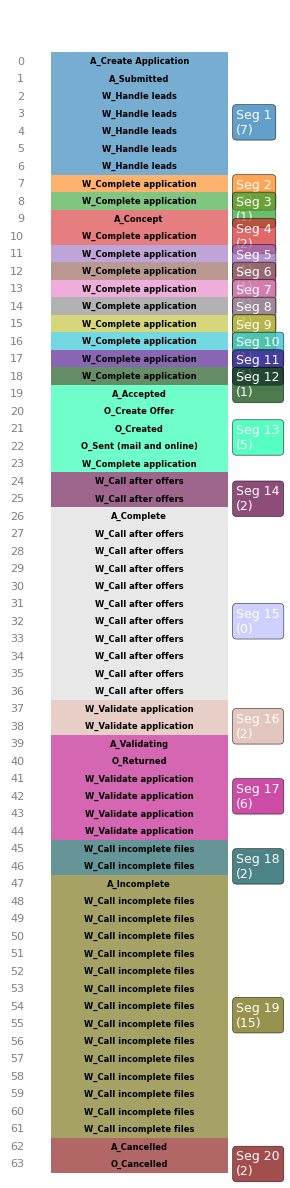

In [24]:
init_pd_seg_boundaries = {}
palette = sns.color_palette(cc.glasbey_category10, n_colors=len(init_prob_seg_ids))

for c, seg in enumerate(init_prob_seg_ids):
    if isinstance(seg, set):
        seg = list(seg)
        try:
            init_pd_seg_boundaries[(seg[0], seg[-1])] = palette[c]
        except IndexError as e:
            print("index is ", c, "the error: ", e)

visualize_trace_vertical(trace=case_to_segment.squeeze(0), activity_token_index=0, figsize=(3, 12),
                         seg_boundaries_colors=init_pd_seg_boundaries, activity_lookup=test_log.itos['activity'])

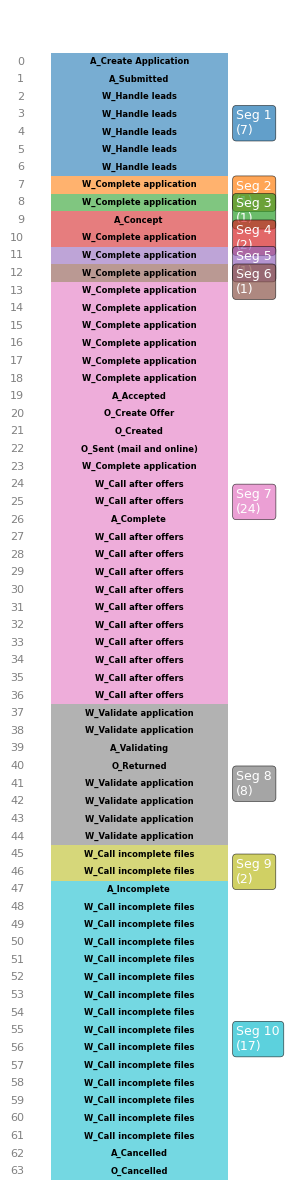

In [25]:
prob_seg_ids_boundaries = {}
palette = sns.color_palette(cc.glasbey_category10, n_colors=len(prob_seg_ids))

for c, seg in enumerate(prob_seg_ids):
    prob_seg_ids_boundaries[(seg[0], seg[-1])] = palette[c]

visualize_trace_vertical(trace=case_to_segment.squeeze(0), activity_token_index=0, figsize=(3, 12),
                         seg_boundaries_colors=prob_seg_ids_boundaries, activity_lookup=test_log.itos['activity'])

In [ ]:
def LZ76(ss):
    """
    Calculate Lempel-Ziv's algorithmic complexity using the LZ76 algorithm
    and the sliding-window implementation.

    Reference:

    F. Kaspar, H. G. Schuster, "Easily-calculable measure for the
    complexity of spatiotemporal patterns", Physical Review A, Volume 36,
    Number 2 (1987).

    Input:
      ss -- array of integers

    Output:
      c  -- integer
    """

    ss = ss.flatten().tolist()
    i, k, l = 0, 1, 1
    c, k_max = 1, 1
    n = len(ss)
    while True:
        if ss[i + k - 1] == ss[l + k - 1]:
            k = k + 1
            if l + k > n:
                c = c + 1
                break
        else:
            if k > k_max:
               k_max = k
            i = i + 1
            if i == l:
                c = c + 1
                l = l + k_max
                if l + 1 > n:
                    break
                else:
                    i = 0
                    k = 1
                    k_max = 1
            else:
                k = 1
    return c


if __name__ == '__main__':
    # Simple string, low complexity
    ss = np.array([0,0,0,0,0,0,0,1,1,1,1,1,1])
    print('The complexity of the string %s is %i'%(ss, LZ76(ss)))

    # Irregular string, high complexity
    ss = np.array([0,1,1,0,1,0,0,1,0,1,1,1,0])
    print('The complexity of the string %s is %i'%(ss, LZ76(ss)))


The complexity of the string [0 0 0 0 0 0 0 1 1 1 1 1 1] is 3
The complexity of the string [0 1 1 0 1 0 0 1 0 1 1 1 0] is 6


## Information-gain-based segmentation

In [ ]:
import numpy as np
from typing import List, Set

def entropy(data: np.ndarray) -> float:
    """
    Calculate the entropy H(s) of a time series segment.
    
    Parameters:
    -----------
    data : np.ndarray
        Time series data segment
        
    Returns:
    --------
    float
        Entropy value
    """
    if len(data) == 0:
        return 0.0
    
    # Simple entropy calculation based on variance
    # You can replace this with a more sophisticated entropy measure
    variance = np.var(data)
    if variance == 0:
        return 0.0
    return 0.5 * np.log(2 * np.pi * np.e * variance)


def IGTS_DP(S: List[np.ndarray], k: int) -> Set[int]:
    """
    Information-Gain-based Time Series Segmentation using Dynamic Programming.
    
    Parameters:
    -----------
    S : List[np.ndarray]
        Set of m time series, each with length n
    k : int
        Number of transition times (segmentation points)
        
    Returns:
    --------
    Set[int]
        Set T of transition times (positions where segments change)
    """
    m = len(S)  # Number of time series
    n = len(S[0])  # Length of each time series
    
    # Initialize W_H matrix: W_H[j, i, h] stores the cost
    # We'll use a 3D array indexed as W_H[j][i][h]
    W_H = np.full((n + 1, n + 1, k + 1), np.inf)
    
    # P matrix to store the position of last transition time
    P = np.zeros((n + 1, k + 1), dtype=int)
    
    # First part: Initialize base cases
    for i in range(1, n + 1):
        for j in range(1, i + 1):
            # Calculate entropy for each time series from position j to i
            total_entropy = 0.0
            for series_idx in range(m):
                segment = S[series_idx][j-1:i]  # Extract segment
                H_s = entropy(segment)
                total_entropy += H_s
            
            # W_H(j, i, 1) = |s_1|/|S| * H(s_1) = (i-j+1)/n * H(s_1)
            segment_length = i - j + 1
            W_H[j][i][1] = (segment_length / n) * total_entropy
    
    # Second part: Dynamic programming
    for h in range(2, k + 1):
        for i in range(1, n + 1):
            # Initialize with previous level
            W_H[1][i][h] = W_H[1][i][h - 1]
            P[i][h] = 1
            
            for j in range(1, i):
                # Check if splitting at position j gives better result
                cost = W_H[1][j][h - 1] + W_H[j + 1][i][1]
                
                if cost <= W_H[1][i][h]:
                    W_H[1][i][h] = cost
                    P[i][h] = j
    
    # Backtrack to find transition times
    T = set()
    NextT = n
    
    for h in range(0, k - 1):
        NextT = P[NextT][k - h]
        T.add(NextT)
    
    return T
